The basic aim of this kernel is to introduce the topics of Fine-Tuning and Class Activation Maps on the Pneumonia X-ray images dataset.

The reason why I find this problem particularly useful is more than 1 million adults are hospitalized with pneumonia and around 50,000 die from the disease every year in the US alone. Chest X-rays are currently the best available method for diagnosing pneumonia , playing a crucial role in clinical care and epidemiological studies . However, detecting pneumonia in chest X-rays is a challenging task that relies on the availability of expert radiologists(as reported by WHO).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import os

In [ ]:
categories=['Covid','Normal','Viral Pneumonia']

In [ ]:
train_dir = '/content/drive/My Drive/Covid19-dataset/train/'
test_dir = '/content/drive/My Drive/Covid1/Covid19-dataset/test/'

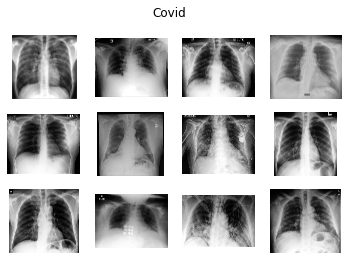

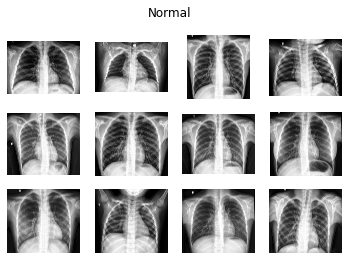

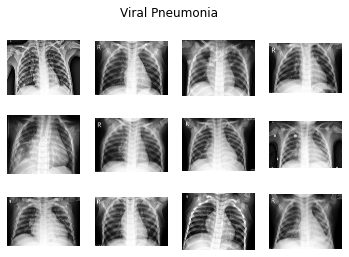

In [ ]:
for category in categories:
  fig, _=plt.subplots(3,4)
  fig.suptitle(category)
  for k, v in enumerate(os.listdir(train_dir+category) [:12]):
    img=plt.imread(train_dir+category+'/'+v)
    plt.subplot(3,4,k+1)
    plt.axis("off")
    plt.imshow(img)
  plt.show()

i am going to split data into  train and test and vaildation part by Imgaegenerators

In [ ]:

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'


LR = 1e-5
height=150
width=150
channels=3
seed=1337
batch_size = 64 #Number of images to load at each iteration
num_classes = 3
epochs = 200
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples
validation_num

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


66

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(height, width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        1

In [ ]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 1.7030 - acc: 0.3802
Epoch 00001: val_acc improved from -inf to 0.18750, saving model to /content/model.h5f
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/model.h5f/assets
3/3 [==============================] - 55s 18s/step - loss: 1.7030 - acc: 0.3802 - val_loss: 1.1204 - val_acc: 0.1875
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 1.1953 - acc: 0.3333
Epoch 00002: val_acc improved from 0.18750 to 0.34375, saving model to /content/model.h5f
INFO:tensorflow:Assets written to: /content/model.h5f/assets
3/3 [==============================] - 16s 5s/step - loss: 1.1953 - acc: 0.3333 - val_loss: 1.102

In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics 
%matplotlib inline
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(validation_generator.classes,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
confusion_mtx

Instructions for updating:
Please use Model.predict, which supports generators.


array([[26,  0,  0],
       [ 0, 18,  2],
       [ 0,  4, 16]])

In [ ]:
total=26+18+16+4+2

In [ ]:

accuracy = (26+18+16)/total
print("Accuracy : %.2f%%" % (accuracy*100.0))

Accuracy : 90.91%


In [ ]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.82      0.90      0.86        20
           2       0.89      0.80      0.84        20

    accuracy                           0.91        66
   macro avg       0.90      0.90      0.90        66
weighted avg       0.91      0.91      0.91        66



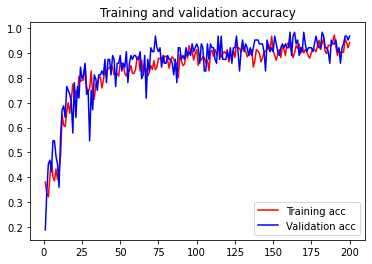

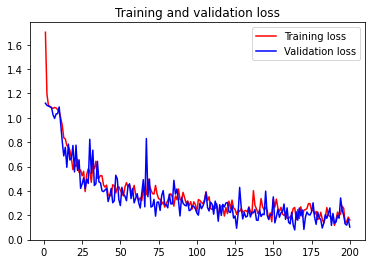

In [ ]:
#Plot Training and validation accuracy and Training and validation loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
path='/content/drive/My Drive/Covid_model_save/'
model.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Covid_model_save/assets


In [ ]:
import cv2
test_data=[]
test_image_o=cv2.imread('/content/drive/My Drive/Covid19-dataset/test/Viral Pneumonia/0104.jpeg')
test_image=cv2.resize(test_image_o,(width,height))# .flatten()
test_data.append(test_image)

# scale the raw pixel intensities to the range [0, 1]
test_data=np.array(test_image,dtype="float")/255.0
test_data=test_data.reshape([-1,224, 224, 3])
pred = model_trained.predict_generator(test_data)
predictions =np.argmax(pred, axis=1) # return to label
print ('Prediction : '+categories[predictions[0]])

Prediction : Viral Pneumonia


I am going to train my model in VGG16 and ResNet50 pre traind model to impove my accuracy batter than other model




# Fine Tuned Model
To train a neural network from scratch,we need a lot of data also lot of processing power and time , which is obviously unavailble and impractical. Therefore, we fine-tune pretrained neural networks. There are a lot of neural networks pretrained on billions of images, that can be used by changing the top layer as per our data.But we use a better technique than that called fine-tuning in which we tweak the parameters of an already trained network so that it adapts to the new task at hand. 

The initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact ( or freeze them ) and retrain the later layers for our task.

I have used the VGG16 model and added my own dense layers at the bottom, then I freeze the network upto the second last convolutional block, after which I retrain.

![](https://i.imgur.com/Jjh8f0z.png)

In [ ]:
#import library 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from keras.applications import vgg16
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(width, height, 3), pooling="max")

for layer in model.layers[:-5]:#freeze all layers except the last ten
        layer.trainable = False
#Check the trainable status of the individual layers        
for layer in model.layers:
    print(layer, layer.trainable)

58892288/58889256 [==============================] - 2s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9e455df2e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9e45331ac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9e45331a58> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9e44b0c6a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9e44ad13c8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9e44ad1b70> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9e44ad62b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9e44ad6b00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9e44adf978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9e44adfa20> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9e44ae8978> Fals

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential

# Although this part can be done also with the functional API, I found that for this simple models, this becomes more intuitive
transfer_model = Sequential()
for layer in model.layers:
    transfer_model.add(layer)
transfer_model.add(Dense(512, activation="relu"))  # Very important to use relu as activation function, search for "vanishing gradiends" :)
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(3, activation="softmax")) # Finally our activation layer! we use 10 outputs as we have 3 covid case(covid normal varial pnemoniea ) (labels)


In [ ]:
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [ ]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)

transfer_model.compile(loss="categorical_crossentropy",
                      optimizer=adam,
                      metrics=["accuracy"])

In [ ]:
learning_rate = 5e-5

checkpoint = ModelCheckpoint("sign_classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [ ]:
model_history = transfer_model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=50,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                             callbacks=[checkpoint], 
                              verbose = 1)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.2798 - acc: 0.3209 
Epoch 00001: val_acc improved from -inf to 0.62500, saving model to sign_classifier.h5
3/3 [==============================] - 73s 24s/step - loss: 1.2798 - acc: 0.3209 - val_loss: 0.9168 - val_acc: 0.6250
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.9733 - acc: 0.5187
Epoch 00002: val_acc did not improve from 0.62500
3/3 [==============================] - 12s 4s/step - loss: 0.9733 - acc: 0.5187 - val_loss: 0.7997 - val_acc: 0.6094
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.8091 - acc: 0.6562
Epoch 00003: val_acc improved from 0.62500 to 0.84375, saving model to sign_classifier.h5
3/3 [==============================] - 12s 4s/step - loss: 0.8091 - acc: 0.6562 - val_loss: 0.5992 - val_acc: 0.8438
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 0.7287 - acc: 0.6

In [ ]:
from tensorflow import keras
model = keras.models.load_model("sign_classifier.h5")

In [ ]:
for metric in model_history.history.keys():
    print(metric)

loss
acc
val_loss
val_acc


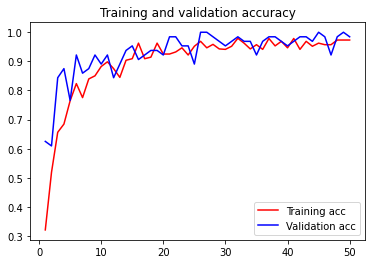

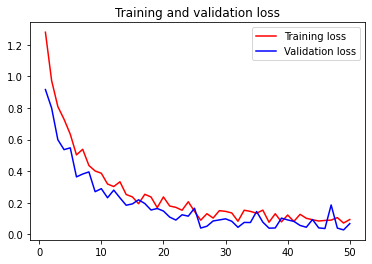

In [ ]:
#Plot Training and validation accuracy and Training and validation loss
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
Y_pred = transfer_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred
#validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 98.5% 


In [ ]:
print(metrics.classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.95      0.97        20
           2       0.95      1.00      0.98        20

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



In [ ]:
test_generator

In [ ]:
path='/content/drive/My Drive/Covid_model_save/sign_classifier_100%.h5'
model.save(path)

In [ ]:
loss,acc=vgg_conv.evaluate(test_data,test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)